In [1]:
import numpy as np
from jax import random

import matplotlib.pyplot as plt

from vpsto.vptraj import VPTraj
from vpsto.vptraj_jax import sample_via_points, batched_get_T_vel, batched_get_trajectory

%reload_ext autoreload
%autoreload 2

key = random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
ndof = 2
batch_size = 1000
N_via = 20
N_eval = 100

q0 = np.array([0., 0.])
dq0 = np.array([0., 0.])
dqT = np.array([0., 0.])
mu_qT = np.array([1., 1.])

mu_prior = np.zeros(N_via * ndof)
mu_prior[(N_via//2-1)*ndof:N_via//2*ndof] = np.array([0.1, 0.9])
P_prior = np.zeros((N_via*ndof, N_via*ndof))
P_prior[(N_via//2-1)*ndof:N_via//2*ndof, (N_via//2-1)*ndof:N_via//2*ndof] = np.eye(ndof)

vel_lim = np.array([1., 1.])
acc_lim = np.array([1., 1.])

vptraj = VPTraj(ndof, N_eval, N_via, vel_lim, acc_lim)

R = 2e-1
# Create a grid of Q values and P_prior values
Qs = np.array([0, 5e2, 1e6])
Ps = np.array([0, 5e2, 1e6])

In [3]:
p = sample_via_points(batch_size, N_via, q0, dq0, R, mu_qT, Qs[0], mu_prior, P_prior, key)
T = batched_get_T_vel(p, q0, dq0, dqT, vel_lim)
q, dq, ddq = batched_get_trajectory(N_eval, p, T, q0, dq0, dqT)

In [4]:
%%timeit -n 500
p = sample_via_points(batch_size, N_via, q0, dq0, R, mu_qT, Qs[0], mu_prior, P_prior, key)

765 µs ± 84.5 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)


In [5]:
%%timeit -n 500
T = batched_get_T_vel(p, q0, dq0, dqT, vel_lim)

977 µs ± 54.1 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)


In [6]:
%%timeit -n 500
q, dq, ddq = batched_get_trajectory(N_eval, p, T, q0, dq0, dqT)

547 µs ± 27.8 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)


In [10]:
Q_list = []
T_list = []

for Q in Qs:
    for P in Ps:
        key, subkey = random.split(key)
        P_prior[(N_via//2-1)*ndof:N_via//2*ndof, (N_via//2-1)*ndof:N_via//2*ndof] = np.diag(np.array([P, P]))
        p = sample_via_points(batch_size, N_via, q0, dq0, R, mu_qT, Q, mu_prior, P_prior, subkey)
        T = batched_get_T_vel(p, q0, dq0, dqT, vel_lim)
        q, dq, ddq = batched_get_trajectory(N_eval, p, T, q0, dq0, dqT)
        Q_list.append(q)
        T_list.append(T)

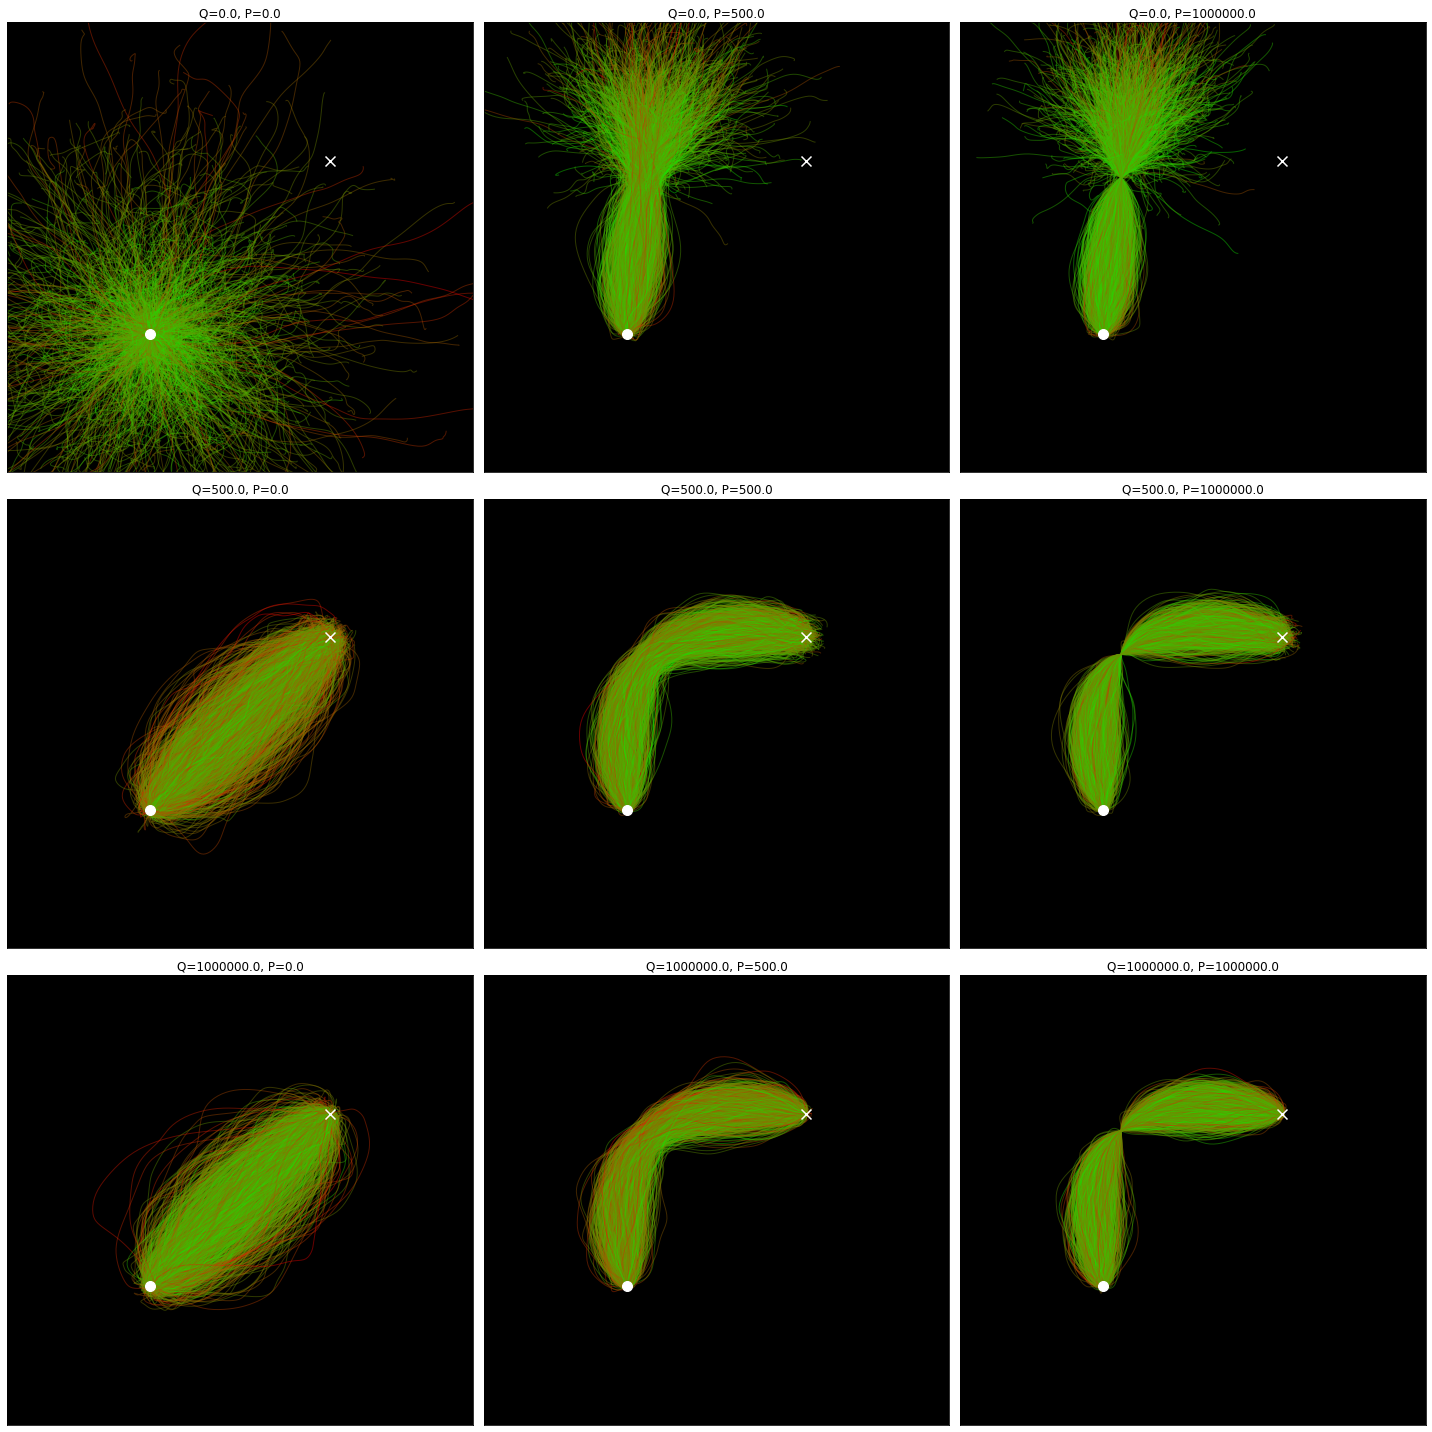

In [11]:
# Create a subplot with 3 rows and 3 columns
num_rows = 3
fig, axs = plt.subplots(num_rows, num_rows, figsize=(20,20))

# set black background
for ax in axs.flat:
    ax.set_facecolor('k')

for i in range(num_rows):
    for j in range(num_rows):
        idx = i*num_rows + j
        q = np.array(Q_list[idx])
        T = np.array(T_list[idx])
        rewards = 1 - (T - np.min(T)) / (np.max(T) - np.min(T))
        for n in range(batch_size):
            c = (1-float(rewards[n]), rewards[n], 0)
            axs[i,j].plot(q[n,:,0], q[n,:,1], color=c, lw=1, alpha=.4)
        axs[i,j].scatter(mu_qT[0], mu_qT[1], color='w', marker='x', s=100, zorder=10)
        axs[i,j].scatter(mu_prior[0], mu_prior[1], color='w', marker='o', s=100, zorder=10)
        axs[i,j].set_title(f"Q={Qs[i]}, P={Ps[j]}")
        axs[i,j].set_xlim([-.8,1.8])
        axs[i,j].set_ylim([-.8,1.8])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

plt.tight_layout()